## Shor's Algorithm

Shor's algorithm is a famous algorithm developed by Peter Shor in 1994 for factorising integers in log N time. It is a big focus of modern research $$$, because if you can factorise large numbers quickly then you can break most public-key encryption schemes like RSA.

The algorithm relies on finding the period of a number in modulo N; the efficiency of the Quantum Fourier Transform; and, most crucially, an ideal Quantum Computer with minimal noise and decoherence.

Shor's algorithm, for all intensive purposes, is $O\big((log N)^3)$, where as classical computers take $O\Big(\exp\big((\log N)^{1/3} (\log \log N)^{2/3}\big)\Big)$. I think this motivates taking a look at the algorithm.

Shor's groundbreaking paper can be found here: https://arxiv.org/abs/quant-ph/9508027

In [138]:
import os
import sys
import numpy as np
import math
from fractions import Fraction
from dotenv import load_dotenv
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import *
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import (SamplerV2 as Sampler)
from qiskit.primitives import (BackendSamplerV2)
from requests.packages import target

In [2]:
# Fetch API token and instance CRN. Stored locally in a .env file and not pushed, for obvious reasons.
load_dotenv()
API_TOKEN = os.getenv('API_TOKEN')
CRN = os.getenv('CRN')

In [3]:
# Connect to least busy backend.
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from ibmq_connect import ibmq_connect_least_busy
backend = ibmq_connect_least_busy(API_TOKEN, CRN)

qiskit_runtime_service._discover_account:WARNING:2025-11-08 19:58:06,609: Loading account with the given token. A saved account will not be used.


Name: ibm_fez
Version: 2
No. of qubits: 156



### 1. Overview of the Algorithm

#### 1.1 Algorithm:
Shor's algorithm is split into two parts: that which can be done on a classical computer, and that needed to be done on a Quantum Computer for speed-up. Without going into too much of the maths, factoring an integer N looks like:

CLASSICAL STEPS: Find integer coprime to N.
   - 1. Pick a random integer a where 1 < a < N.
   - 2. Compute K = GCD(a, N) using Euclidean Algorithm (which is O(log n)).
   - 3. If K $\neq$ 1 then K is a factor of N --> break.

QUANTUM STEP: Find the period of that coprime number in modulo N.
   - 4. Find quantum period r, which is the smallest integer that solves $a^r$ = 1 mod N.

CLASSICAL STEPS: Use period to construct factors of N.
   - 5. If r is odd, back to step 1.
   - 6. If $a^{r/2} = -1 \text{ mod } N$. back to step 1.
   - 7. Otherwise, Both GCD($a^{r/2} + 1, N) \text{ and } $GCD$(a^{r/2} - 1, N)$ are non-trivial factors of $N$.

As to why the last steps work, we have that $(a^{r/2} + 1)(a^{r/2} - 1) = a^{r} - 1 \equiv 0$ mod $N.$

#### 1.2 Period Finding:

A periodic function looks like:
$$
f(x) \equiv a^x \text{ mod } N
$$
We would like to know the period r $>0$, the smallest integer that solves
$$
a^r \text{ mod } N \equiv 1
$$
This is the part that Shor's algorithm actually solves. The solution is to use a phase estimation on the unitary operator:
$$
U |x\rangle \equiv |ax \text{ mod } N \rangle
$$
I spent a while looking at walls of eigenstates to try and understand this, but breaking it down helps: starting at $|1\rangle$, how many times do we have to apply U to get $|1\rangle$ again? I.e. what x gives $U^x |1\rangle = |1\rangle$, where U corresponds to the gate that multiplies the register by a ( mod N ). Being able to evaluate all $U^x$ at once gives a significant speed-up over classical registers.

If we look at N=15 (which IBM proved can be calculated in 2001) then a could be any of a = [2, 4, 7, 8, 11, 13] since GCD(a, 15) = 1. Picking a = 2 gives :
$$
2^1 \equiv 2 \text{ mod } 15
$$
$$
2^2 \equiv 4 \text{ mod } 15
$$
$$
2^3 \equiv 8 \text{ mod } 15
$$
$$
2^4 = 16 \equiv 1 \text{ mod } 15
$$
Therefore r = 4. Check $2^{4/2} = 4 \neq -1$ mod $15$ so conditions satisfied, then:
$$
    GCD(2^{r/2} - 1, 15) = GCD(3, 15) = 5
$$
$$
    GCD(2^{r/2} + 1, 15) = GCD(5, 15) = 3
$$
The goal is to superposition x=1,2,3,4,... and evaluate $a^x$ mod $N$ in parallel. It is generally advised to use double the number of qubits to describe x, as to describe N. 4 qubits are needed for N=15, so m=8 qubits will be needed for x, giving a range of periods from 1 to 255. This represents the Unitary Matrices $U^1, ..., U^{255}$.

#### 1.3 Quantum Circuit
Shor's circuit for the quantum steps works in three parts:
   - Build target register corresponding to $|1\rangle$. Also build a counting register for state $|x\rangle$, and put into equal super position $|+\rangle$.
   - Apply the modular exponentiation unitary $|x\rangle|1\rangle \rightarrow |x\rangle|a^x \text{ mod } N \rangle$
   - Apply an Inverse Quantum fourier transform on the counting register to extract (though not directly) the period r, from possible x values. Measuring after this gives us a value that can be used to classically recover r. More on this later, one step at a time.

The Inverse Quantum fourier transform works much like a classical fourier transform, but with qubits. It takes the state, which acts like a smooth wave with some hidden period and converts it to a sharp peak with a frequency.

### 2. Basic Implementation
To start out, I am not going to worry about the intricacies of the Unitary Gate and Quantum Fourier Transform and just import the relevant packages from Qiskit. I will work on the example N = 15, and pick a = 2, as it is coprime to 15 and the period works. Thats steps 1,2 and 3 out of the way.

C:\Users\willd\AppData\Local\Temp\ipykernel_50784\1528720011.py:78: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  inv_qft = QFT(num_counting_qubits, inverse=True, do_swaps=True).to_instruction()


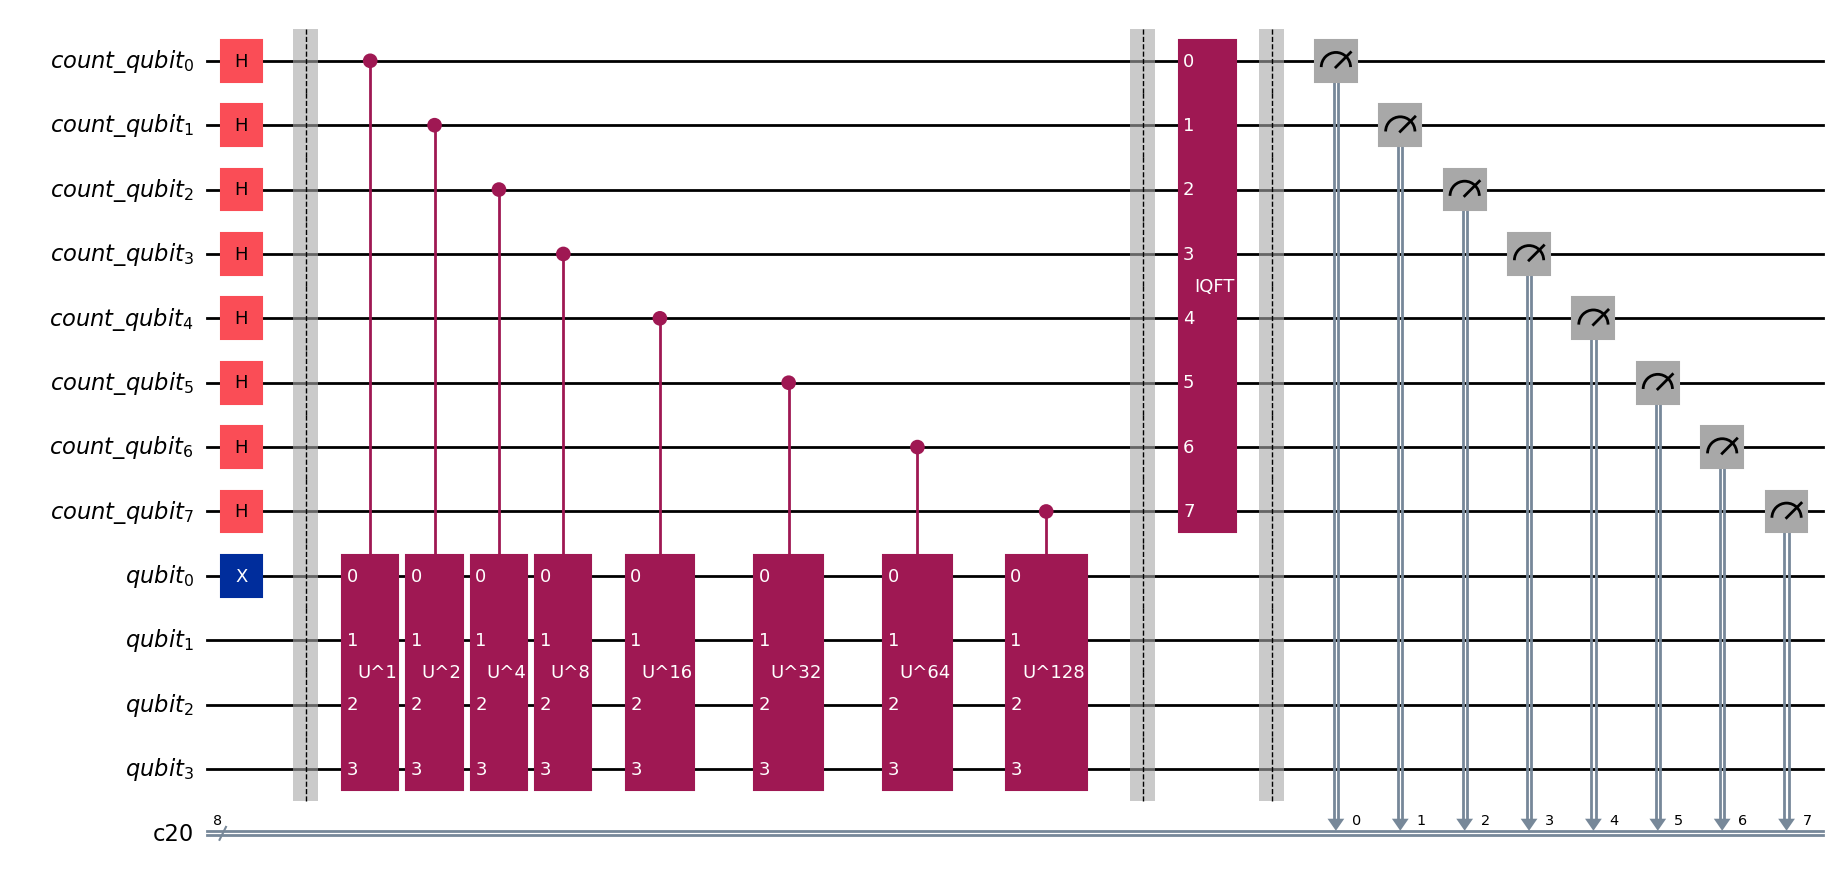

In [142]:
from qiskit.circuit.library import UnitaryGate, QFT # import Unitary Gate and Quantum Fourier Transform

# ------ Parameters ------

N: int = 15
a_list: list[int] = [2, 4, 7, 8, 11, 13, 14]
a = 2

num_qubits: int = N.bit_length() # (n) number of qubits to represent N
num_counting_qubits: int = 2*num_qubits   # counting register. Used to store phase information encoding r.

def shors_circuit(a, N, num_qubits, num_counting_qubits):
    """
    Builds a quantum circuit for the quantum part of Shor's algorithm.

    Parameters
    ----------
    a : int
        An integer coprime to N, for which we want to find the period of a^x mod N.
    N : int
        The integer to be factorized.
    num_qubits : int
        Number of qubits in the target register (used to store |1> initially).
    num_counting_qubits : int
        Number of qubits in the counting register (used to estimate the period).

    Returns
    -------
    QuantumCircuit
        A Qiskit QuantumCircuit object for Shor's algorithm.
    """

    # ------ Build Register ------
    qr_counting = QuantumRegister(num_counting_qubits, 'count_qubit') # register for counting
    qr_target = QuantumRegister(num_qubits, 'qubit') # register for target state
    cr = ClassicalRegister(num_counting_qubits) # classical register for measuring counting qubits
    qc = QuantumCircuit(qr_counting, qr_target, cr)

    # set counting register into superposition
    qc.h(range(num_counting_qubits))

    # set target register to |1>
    qc.x(num_counting_qubits)

    qc.barrier()


    # ------ Build unitary matrix. ------
    dim = 2**num_qubits
    U = np.zeros((dim, dim), dtype=complex)

    # U acts as |x> -> |a*x mod N> for 0 <= x < 2^n.
    for x in range(dim):
        if x < N:
            u = (a * x) % N
        else:
            # for states outside [0,N-1],leave them unchanged
            u = x
        U[u, x] = 1.0


    # ------ Apply all Unitary Gates to each counting qubit ------
    for j in range(num_counting_qubits):
        # set power, so that we have U^0, U^1, U^2, U^4,... applied to each counting qubit.
        power = 2**j

        U_power = np.linalg.matrix_power(U, power) # calculate U^x
        U_gate = UnitaryGate(U_power, label=f"U^{power}") # build Unitary Gate from U^x
        controlled_U_gate = U_gate.control()  # controlled on 1 qubit

        # add gate to circuit: counting qubit j acts as the control qubit, while the gate acts on the target qubits
        qc.append(controlled_U_gate, [j] + [num_counting_qubits + i for i in range(num_qubits)])

    qc.barrier()


    # ------ Apply inverse QFT on counting register ------
    inv_qft = QFT(num_counting_qubits, inverse=True, do_swaps=True).to_instruction()
    qc.append(inv_qft, list(range(num_counting_qubits)))
    qc.barrier()


    # ------ Measure Counting Qubits -------
    for i in range(num_counting_qubits):
        qc.measure(i, i)

    return qc

qc = shors_circuit(a, N, num_qubits, num_counting_qubits)
qc.draw('mpl')

I think this helps visualise what is going on. It gives a good idea of how we apply all powers $a^x$. The counting bits acting as controls let us build all the unitary gates. For example, state x = 10100100 gives $U^{1}U^{4}U^{32} = U^{37}$, corresponding to $a^{37}$ mod N. Nice!

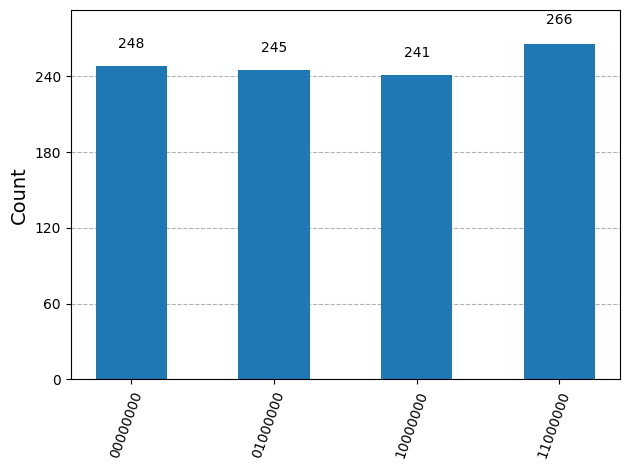

In [144]:
# ------ Run Simulation on Backend ------
def simulate_backend(qc):
    """ Runs quantum circuit on simulated backend and returns counts. """
    backend = Aer.get_backend('qasm_simulator')
    qc = transpile(qc, backend)
    job = backend.run(qc, shots=1000)
    result = job.result().get_counts()
    return result

result = simulate_backend(qc)
plot_histogram(result)

Great, some results that I am unable to interpret. It is easy to read off that these bits correspond to 0, 1, 2 and 3. Shor's algorithm guarantees (with high probability) that:
$$
\frac{x}{2^{m}} \approx \frac{k}{r}
$$
where m is the number of counting bits, and k is some integer unknown to us. I was getting quite a few issues reading off these values and trying to apply continued fractions to the results. It turns out that the standard Quantum Fourier Transform on n-qubits ends up reversing the order of the qubits by a series of Hadamard gates and phase rotations. Teaches me right for not researching it before I implemented it. Easy fix with 'do_swaps=True'.

We can read off the results x = 0, 64, 128, 192. Disregard 0, so k/r = 1/4, 1/2, 3/4. Since k is an integer, we get r = 4, 2, 4.

In [137]:
def find_r(_x, m):
    """ Find period by continued fractions """
    frac = Fraction(_x, 2**m).limit_denominator() # find the simplest fraction closest to C/2^m
    r = frac.denominator
    return r

def get_period(counts):
    """ Get period from set of phase estimations """

    # -- convert measurements to integers __
    vals = []
    for bitstring, _ in counts.items():
        x = int(bitstring, 2)
        if x != 0: vals.append(x)

    # -- get candidate periods --
    r_candidates = [find_r(_x, num_counting_qubits) for _x in vals]

    # -- generate periods and check against algorithm constraints. --
    r_vals = [r for r in r_candidates if (pow(a, r, N) == 1) and (r%2 == 0) and (pow(a, int(r/2), N) != 1)]
    period = min(r_vals)

    print("Raw x values:", vals)
    print("Candidate r:", r_candidates)
    print("Valid r:", r_vals)
    print("Period:", period)

    return period

_r = get_period(result)

Raw x values: [64, 128, 192]
Candidate r: [4, 2, 4]
Valid r: [4, 4]
Period: 4


In [140]:
def get_factors(a, r, N):
    """ Get factors from a, r and N """
    f1 = math.gcd(pow(a, r//2, N) + 1, N)
    f2 = math.gcd(pow(a, r//2, N) - 1, N)
    return f1, f2

_f1, _f2 = get_factors(a, _r, N)
print('Factors:', _f1, _f2)

Factors: 5 3
